In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 21:38:50.647227: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 21:38:52.023223: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 21:38:52.066349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 21:38:52.066406: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 21:38:52.071900: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 21:38:52.071958: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 21:38:52.074305: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

eco_gen_GASF_13m_100S5X11A38085_R42_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 4.72665218740304, 1: 0.17788312772578393, 2: 0.5904536733784229, 3: 2.508893280632411, 4: 2.2035148622260796, 5: 10.612330198537094, 6: 0.8248416265092858, 7: 3.213246150601139, 8: 1.347843397478434, 9: 5.1869254341164455, 10: 14.655122655122655}
 
Tests 
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/eco/TL/eco_42_refit, iawe, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data eco training on model refit seed 42
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 4.72665218740304, 1: 0.17788312772578393, 2: 0.5904536733784229, 3: 2.508893280632411, 4: 2.2035148622260796, 5: 10.612330198537094, 6: 0.8248416265092858, 7: 3.213246150601139, 8: 1.347843397478434, 9: 5.1869254341164455, 10: 14.655122655122655}
 
Tests 
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189
loading model
compling TL model..


2022-02-11 21:38:54.073655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 21:38:54.073985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 21:38:54.074036: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 21:38:54.438514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 21:38:54.438548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 21:38:54.438555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 21:38:54.439132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 21:39:02.214844: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 21:39:02.232561: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 21:39:05.689417: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 21:39:06.182748: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 21:39:06.669289: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 21:39:07.082027: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


953/953 - 24s - loss: 0.8618 - accuracy: 0.6309
Epoch 2/50
953/953 - 23s - loss: 0.6160 - accuracy: 0.7245
Epoch 3/50
953/953 - 23s - loss: 0.5717 - accuracy: 0.7431
Epoch 4/50
953/953 - 23s - loss: 0.5455 - accuracy: 0.7502
Epoch 5/50
953/953 - 23s - loss: 0.5270 - accuracy: 0.7581
Epoch 6/50
953/953 - 23s - loss: 0.5251 - accuracy: 0.7607
Epoch 7/50
953/953 - 22s - loss: 0.5154 - accuracy: 0.7632
Epoch 8/50
953/953 - 23s - loss: 0.5052 - accuracy: 0.7705
Epoch 9/50
953/953 - 24s - loss: 0.4959 - accuracy: 0.7713
Epoch 10/50
953/953 - 22s - loss: 0.4937 - accuracy: 0.7766
Epoch 11/50
953/953 - 22s - loss: 0.4877 - accuracy: 0.7725
Epoch 12/50
953/953 - 23s - loss: 0.4778 - accuracy: 0.7801
Epoch 13/50
953/953 - 24s - loss: 0.4780 - accuracy: 0.7799
Epoch 14/50
953/953 - 23s - loss: 0.4726 - accuracy: 0.7779
Epoch 15/50
953/953 - 23s - loss: 0.4667 - accuracy: 0.7830
Epoch 16/50
953/953 - 22s - loss: 0.4647 - accuracy: 0.7848
Epoch 17/50
953/953 - 23s - loss: 0.4642 - accuracy: 0.7835


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.5039 - accuracy: 0.4326
Epoch 2/50
953/953 - 22s - loss: 1.1479 - accuracy: 0.5010
Epoch 3/50
953/953 - 22s - loss: 1.0728 - accuracy: 0.5355
Epoch 4/50
953/953 - 23s - loss: 1.0136 - accuracy: 0.5396
Epoch 5/50
953/953 - 22s - loss: 0.9856 - accuracy: 0.5631
Epoch 6/50
953/953 - 23s - loss: 0.9540 - accuracy: 0.5666
Epoch 7/50
953/953 - 23s - loss: 0.9364 - accuracy: 0.5789
Epoch 8/50
953/953 - 23s - loss: 0.9166 - accuracy: 0.5821
Epoch 9/50
953/953 - 22s - loss: 0.9239 - accuracy: 0.5868
Epoch 10/50
953/953 - 23s - loss: 0.9069 - accuracy: 0.5901
Epoch 11/50
953/953 - 23s - loss: 0.8939 - accuracy: 0.5938
Epoch 12/50
953/953 - 23s - loss: 0.8835 - accuracy: 0.6013
Epoch 13/50
953/953 - 22s - loss: 0.8864 - accuracy: 0.6046
Epoch 14/50
953/953 - 22s - loss: 0.8547 - accuracy: 0.6131
Epoch 15/50
953/953 - 23s - loss: 0.8767 - accuracy: 0.6098
Epoch 16/50
953/953 - 22s - loss: 0.8670 - accuracy: 0.6139
Epoch 17/50
953/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.1537 - accuracy: 0.5849
Epoch 2/50
953/953 - 23s - loss: 0.8584 - accuracy: 0.6544
Epoch 3/50
953/953 - 23s - loss: 0.7867 - accuracy: 0.6749
Epoch 4/50
953/953 - 23s - loss: 0.7427 - accuracy: 0.6792
Epoch 5/50
953/953 - 22s - loss: 0.7093 - accuracy: 0.6905
Epoch 6/50
953/953 - 23s - loss: 0.6904 - accuracy: 0.7002
Epoch 7/50
953/953 - 22s - loss: 0.6946 - accuracy: 0.7016
Epoch 8/50
953/953 - 24s - loss: 0.6675 - accuracy: 0.7081
Epoch 9/50
953/953 - 22s - loss: 0.6770 - accuracy: 0.7071
Epoch 10/50
953/953 - 22s - loss: 0.6612 - accuracy: 0.7147
Epoch 11/50
953/953 - 23s - loss: 0.6520 - accuracy: 0.7137
Epoch 12/50
953/953 - 24s - loss: 0.6444 - accuracy: 0.7136
Epoch 13/50
953/953 - 23s - loss: 0.6279 - accuracy: 0.7245
Epoch 14/50
953/953 - 23s - loss: 0.6209 - accuracy: 0.7297
Epoch 15/50
953/953 - 23s - loss: 0.6213 - accuracy: 0.7257
Epoch 16/50
953/953 - 23s - loss: 0.6134 - accuracy: 0.7317
Epoch 17/50
953/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.0662 - accuracy: 0.5136
Epoch 2/50
953/953 - 23s - loss: 0.8121 - accuracy: 0.6269
Epoch 3/50
953/953 - 22s - loss: 0.7560 - accuracy: 0.6495
Epoch 4/50
953/953 - 22s - loss: 0.7318 - accuracy: 0.6605
Epoch 5/50
953/953 - 23s - loss: 0.6855 - accuracy: 0.6746
Epoch 6/50
953/953 - 23s - loss: 0.6928 - accuracy: 0.6755
Epoch 7/50
953/953 - 23s - loss: 0.6708 - accuracy: 0.6831
Epoch 8/50
953/953 - 23s - loss: 0.6597 - accuracy: 0.6956
Epoch 9/50
953/953 - 22s - loss: 0.6472 - accuracy: 0.6983
Epoch 10/50
953/953 - 23s - loss: 0.6335 - accuracy: 0.7023
Epoch 11/50
953/953 - 22s - loss: 0.6411 - accuracy: 0.6975
Epoch 12/50
953/953 - 23s - loss: 0.6382 - accuracy: 0.7072
Epoch 13/50
953/953 - 23s - loss: 0.6131 - accuracy: 0.7142
Epoch 14/50
953/953 - 22s - loss: 0.6154 - accuracy: 0.7093
Epoch 15/50
953/953 - 23s - loss: 0.6347 - accuracy: 0.7108
Epoch 16/50
953/953 - 23s - loss: 0.6058 - accuracy: 0.7142
Epoch 17/50
953/

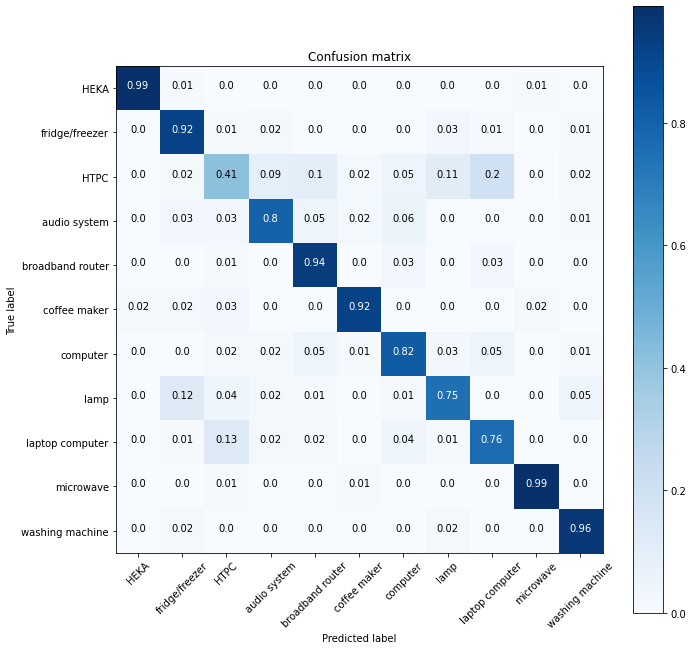

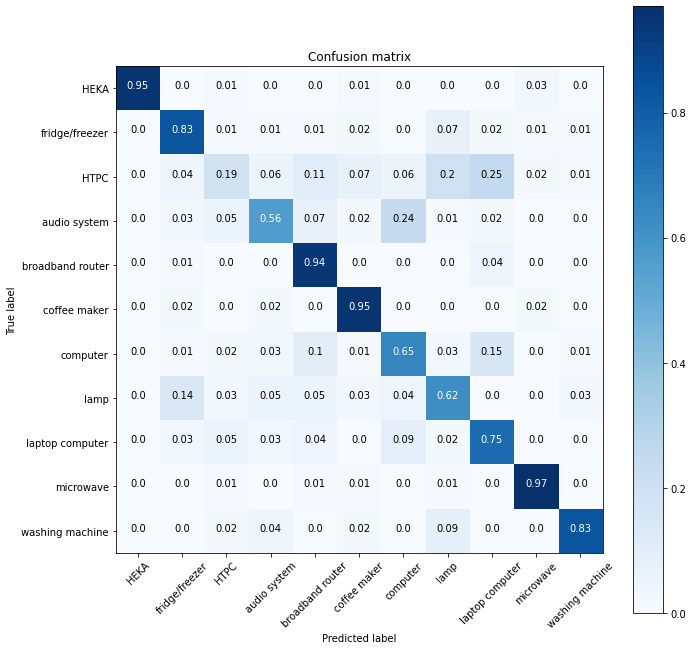

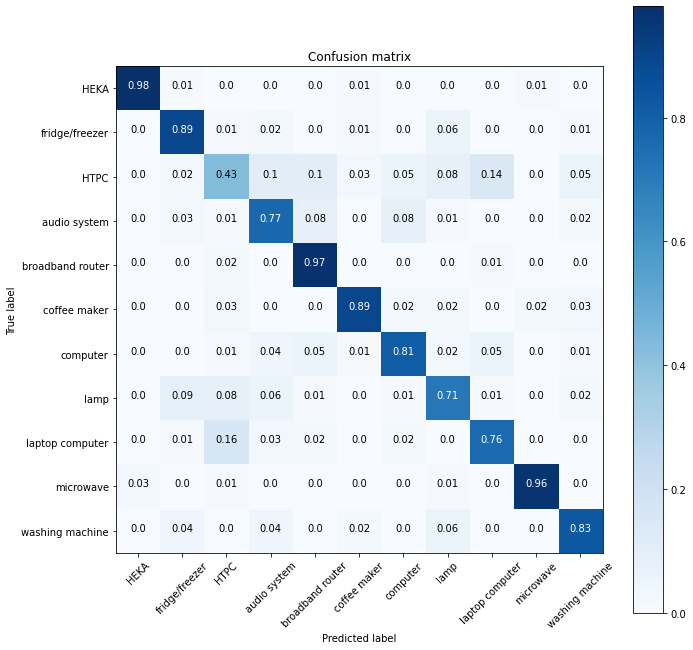

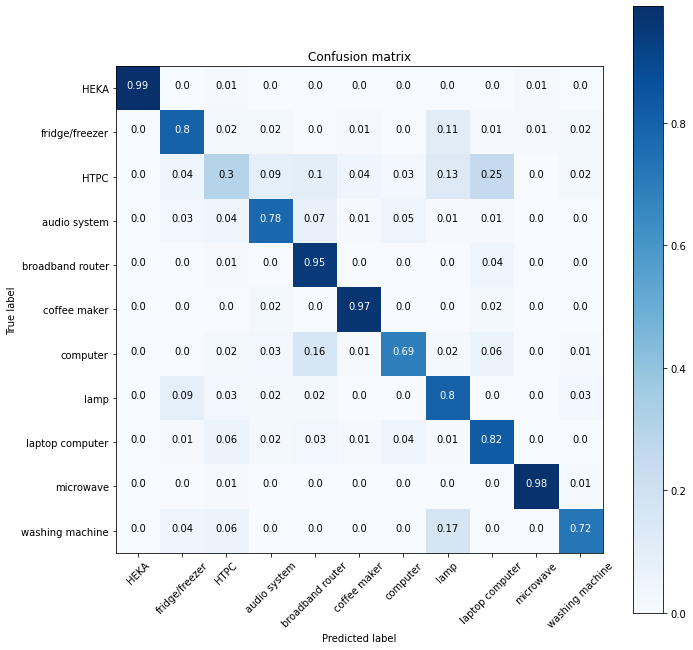

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()